In [1]:
%matplotlib inline

In [2]:
from helper.common_imports import *
from helper.dataset_exploration import *

# 1. load dataset
The dataset is available in the release of the repository, see https://github.com/toinsson/touchclass/releases. Download the files and extract them in the `./dataset` folder.

The dataset includes 12 video recordings of 2 separated classes (touch and non-touch) from two different view angles (close and far, or S4 and S3, respectively) of different 3 finger types (index, thumb and pinky).

In [3]:
datafolder = './dataset/'
df = pd.read_csv(datafolder+'dataset.pd', index_col=0)

In [4]:
df

,user,surface,finger,class,filename,time
0,user_0,S3,index,touch,0.hdf5,2017-03-08_10:48:36
1,user_0,S3,index,notouch,1.hdf5,2017-03-08_10:50:27
2,user_0,S3,thumb,touch,2.hdf5,2017-03-08_10:52:53
3,user_0,S3,thumb,notouch,3.hdf5,2017-03-08_10:54:12
4,user_0,S3,pinky,touch,4.hdf5,2017-03-08_10:55:51
5,user_0,S3,pinky,notouch,5.hdf5,2017-03-08_10:56:57
6,user_0,S4,index,touch,6.hdf5,2017-03-08_11:01:13
7,user_0,S4,index,notouch,7.hdf5,2017-03-08_11:02:24
8,user_0,S4,thumb,touch,8.hdf5,2017-03-08_11:03:39
9,user_0,S4,thumb,notouch,9.hdf5,2017-03-08_11:04:52


Each file in the dataset is in the format hdf5 and contains a data group with 900 depth images of shape with time stamps and frame number, as well as some additional information needed to transform depth images into pointcloud:

- matrix: homography matrix
- origin: origin of the interaction surface
- extrema: boundaries of the interaction surface in pattern coordinates

The video was recorded with a marker in sight, as is common with AR techniques, to indicate the placement of the interactive plane. An homography was computed between the camera and this pattern.

In [5]:
f0 = df.iloc[10]['filename']
hf = h5py.File(datafolder+f0, 'r')

In [6]:
display_dataset_md(hf)

<table>
        <tr>
        <th>name</th>
        <th>shape</th>
        <th>dtype</th>
        </tr>
    <tr>
        <td>data/depth</td>
        <td>(900, 480, 640)</td>
        <td>int16</td>
    </tr>
    <tr>
        <td>data/frame</td>
        <td>(900,)</td>
        <td>int64</td>
    </tr>
    <tr>
        <td>data/time</td>
        <td>(900,)</td>
        <td>|S26</td>
    </tr>
    <tr>
        <td>extrema</td>
        <td>(4,)</td>
        <td>float64</td>
    </tr>
    <tr>
        <td>matrix</td>
        <td>(3, 3)</td>
        <td>float32</td>
    </tr>
    <tr>
        <td>origin</td>
        <td>(3,)</td>
        <td>float32</td>
    </tr>
    <tr>
        <td>pattern</td>
        <td>()</td>
        <td>object</td>
    </tr>
    </table>

# 2. visualise dataset

## a. plot depth

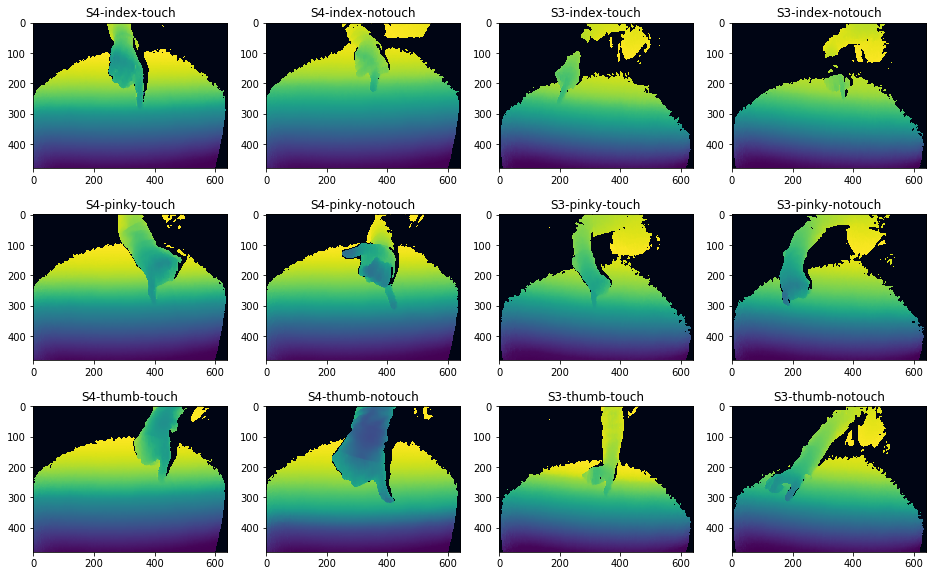

In [7]:
fig, axs = plt.subplots(3,4, figsize=(16,10))

# select the frame id in (0, 899)
image_id = 500

for i, row in enumerate(df.sort_values(by=['finger','surface'], ascending=[True, False]).itertuples()):
    
    idx = np.unravel_index(i, (3,4))
    with h5py.File(datafolder+row.filename, 'r') as hf:
        frame = hf['data/depth'][image_id]
        frame[0,0] = frame[0,1] = 0
    
    rgb_frame = int16_to_rgb(frame)
    axs[idx].imshow(rgb_frame)
    axs[idx].set_title("-".join([row.surface, row.finger, row._4]))

In [8]:
def f(dataset, frame_number):
    fig, ax = plt.subplots(figsize=(16,12))

    with h5py.File(datafolder+df.iloc[dataset]['filename'], 'r') as hf:
        frame = hf['data/depth'][frame_number]
        frame[0,0] = frame[0,1] = 0
    
    rgb_frame = int16_to_rgb(frame)
    ax.imshow(rgb_frame)
    ax.set_title("-".join(df.iloc[dataset][['surface', 'finger', 'class']].values))

w = interactive(f,
                dataset=widgets.IntSlider(min=0, max=11, step=1, value=0, continuous_update=False),
                frame_number=widgets.IntSlider(min=0, max=899, step=1, value=10, continuous_update=False))

In [9]:
display(w)

interactive(children=(IntSlider(value=0, continuous_update=False, description='dataset', max=11), IntSlider(va…

## b. deproject images

The images in the datasets are only the depth images. This information can however be transformed as a pointcloud if the intrinsic parameters of the camera are known. These were saved during the recording of the dataset.

In [10]:
from helper import vtkplot
from helper.projection import projection

In [11]:
filename = row.filename

with h5py.File(datafolder+filename, 'r') as hf:
    X = hf['data/depth'][image_id]
    org = np.array(hf['origin'], dtype=np.float32)
    mat = np.array(hf['matrix'], dtype=np.float32)
    ext = np.array(hf['extrema'], dtype=np.float32)

In [12]:
def transform(X, mat, org):
    # from camera coordinates to pattern coordinates
    return np.dot(mat, (X - org).reshape((-1,3)).T).T

def filter_(pc, ext):
    # restrict to the interactive surface
    xm = (pc[:,0] >= ext[0]) & (pc[:,0] <= ext[1])
    ym = (pc[:,1] >= ext[2]) & (pc[:,1] <= ext[3])
    return pc[xm & ym]

def compute(X, mat, org, ext):
        pc = projection.pixel_to_point(X)
        X = transform(pc, mat, org)
        X = filter_(X, ext)
        return X

In [13]:
res = compute(X, mat, org, ext)

In [ ]:
# press Q to exit the visualisation
# axis shows 10cm in each directions
vtkplot.plot_objects(10*res, axis=True)

# 3. extract ROI
To simplify the task of classsification, it is opportune to remove any pixels in the image that do not contribute to the task or that do no contain salient information. For that matter, a region-of-interest filter is implemented.

In [14]:
from helper import processing as ps

In [15]:
from sklearn import base

In [16]:
class ClipFrame(base.BaseEstimator, base.TransformerMixin):
    #     add init with output size parameter
    def fit(self, x, y=None): return self

    def clip_frame(self, frame, point):
        if (np.array(point) == np.zeros(2)).all():
            res = np.zeros((50,50))
        else:
            res = frame[point[0]:point[0]+50, point[1]-25:point[1]+25]
        return res

    def transform(self, X):
        track_point_idx = X[:2]
        frame = X[2]
        return self.clip_frame(frame, track_point_idx)

In [17]:
a, b, c, d = -25, 75, -50, 50
# a, b, c, d = 0, 28, -14, 14

In [18]:
clip = ClipFrame()

In [19]:
def f(dataset, frame_number):
    fig, ax = plt.subplots(figsize=(16,12))

    frame, mat, org, ext = get_data_from_dataset(datafolder+df.iloc[dataset]['filename'], frame_number)

    rgb_frame = int16_to_rgb(frame)
    
    er = ps.ExtractFeature(ps.Dataset([frame], org, mat, ext))
    roi_idx = er.identify_tracker(frame)
    
    rgb_frame[roi_idx[0]+a:roi_idx[0]+b, roi_idx[1]+c:roi_idx[1]+d] += 10

    r = Rectangle(roi_idx[::-1] - np.array((50,25)), 100, 100, fill=None)
    ax.add_patch(r)    

    ax.imshow(rgb_frame)
    ax.plot(*roi_idx[::-1], 'rx', ms=15)

    ax.set_title("-".join(df.iloc[dataset][['surface', 'finger', 'class']].values) + " {} {}".format(*roi_idx))

In [20]:
w = interactive(f,
         dataset=widgets.IntSlider(min=0, max=11, step=1, value=0, continuous_update=False),
         frame_number=widgets.IntSlider(min=0, max=899, step=1, value=10, continuous_update=False))

In [21]:
display(w)

interactive(children=(IntSlider(value=0, continuous_update=False, description='dataset', max=11), IntSlider(va…

In [22]:
import pcl

In [23]:
def compute_(frame, org, mat, ext):

    pc = projection.pixel_to_point(frame)
    pc_rot = np.dot(mat, (pc - org).reshape((-1,3)).T).T
    pc_rot_org = pc_rot.copy()

    # find pointer
    CLOUD_UPPER_MIN = 0.01  # 1cm, which exclude the plane
    CLOUD_UPPER_MAX = 0.10
    xm = (pc_rot[:,0] >= ext[0]) & (pc_rot[:,0] <= ext[1])
    ym = (pc_rot[:,1] >= ext[2]) & (pc_rot[:,1] <= ext[3])
    zm = (pc_rot[:,2] > CLOUD_UPPER_MIN) & (pc_rot[:,2] < CLOUD_UPPER_MAX)
    pc_rot = pc_rot[xm & ym & zm]
    leaf_size = 0.02
    vpcl = pcl.PointCloud(pc_rot.astype(np.float32))
    vgf = vpcl.make_voxel_grid_filter()
    vgf.set_leaf_size(leaf_size, leaf_size, leaf_size)
    voxel = vgf.filter().to_array()
    closest_y = voxel[np.argsort(voxel[:,1])[-1]]
    track_point_idx_ = np.argmin(np.linalg.norm(pc_rot_org - closest_y, axis=1))
    track_point_idx = np.unravel_index(track_point_idx_, X.shape)

    # prepare frame of rotated pointcloud
    # reorient
    tmp = pc_rot_org * np.array([-1,1,1], dtype=np.float32) + org
    tmp = np.ascontiguousarray(tmp)
    frame_ = projection.point_to_pixel(tmp)
    # mean at plane
    frame_nz = (frame_ != 0)
    frame_[frame_nz] -= frame_[frame_nz].mean()
    # clip
    r = np.argwhere(projection.point_to_pixel((closest_y * np.array([-1,1,1], dtype=np.float32) + org).reshape((1,3))))[0]
    frame_clip = frame_[r[0]-50:r[0]+50, r[1]-50:r[1]+50]
    
    return frame_clip

In [24]:
def f(dataset, frame_number):
    fig, ax = plt.subplots(figsize=(16,12))
    frame, mat, org, ext = get_data_from_dataset(datafolder+df.iloc[dataset]['filename'], frame_number)
    frame_ = compute_(frame, org, mat, ext)
#     rgb_frame = int16_to_rgb(frame)
#     ax[0].imshow(frame)
    cb = ax.imshow(frame_)
    fig.colorbar(cb, ax=ax)

In [25]:
w = interactive(f,
         dataset=widgets.IntSlider(min=0, max=11, step=1, value=0, continuous_update=False),
         frame_number=widgets.IntSlider(min=0, max=899, step=1, value=10, continuous_update=False))

In [26]:
display(w)

interactive(children=(IntSlider(value=0, continuous_update=False, description='dataset', max=11), IntSlider(va…

In [27]:
vtkplot.plot_objects( res * np.array([-1,1,-1], dtype=np.float32) + org, axis=True)

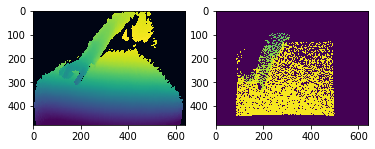

In [28]:
fig, ax = plt.subplots(1,2)

ax[0].imshow(int16_to_rgb(X))
ax[1].imshow(projection.point_to_pixel( np.ascontiguousarray(res * np.array([-1,1,-1], dtype=np.float32) + org )))

In [29]:
import pcl

In [30]:
dataset = 0
frame_number = 130
frame, mat, org, ext = get_data_from_dataset(datafolder+df.iloc[dataset]['filename'], frame_number)

pc = projection.pixel_to_point(frame)
pc_rot = np.dot(mat, (pc - org).reshape((-1,3)).T).T
pc_rot_org = pc_rot.copy()

CLOUD_UPPER_MIN = 0.01  # 1cm, which exclude the plane
CLOUD_UPPER_MAX = 0.10
xm = (pc_rot[:,0] >= ext[0]) & (pc_rot[:,0] <= ext[1])
ym = (pc_rot[:,1] >= ext[2]) & (pc_rot[:,1] <= ext[3])
zm = (pc_rot[:,2] > CLOUD_UPPER_MIN) & (pc_rot[:,2] < CLOUD_UPPER_MAX)
pc_rot = pc_rot[xm & ym & zm]

leaf_size = 0.02
vpcl = pcl.PointCloud(pc_rot.astype(np.float32))
vgf = vpcl.make_voxel_grid_filter()
vgf.set_leaf_size(leaf_size, leaf_size, leaf_size)
voxel = vgf.filter().to_array()

# # find plane
# planePcl = pcl.PointCloud(voxel.astype(np.float32))
# seg = planePcl.make_segmenter()
# seg.set_optimize_coefficients(True)
# seg.set_model_type(pcl.SACMODEL_PLANE)
# seg.set_method_type(pcl.SAC_RANSAC)
# seg.set_distance_threshold(0.002)
# indices, model = seg.segment()
# plane = planePcl.extract(indices, negative=False).to_array()

closest_y = voxel[np.argsort(voxel[:,1])[-1]]
track_point_idx_ = np.argmin(np.linalg.norm(pc_rot_org - closest_y, axis=1))
track_point_idx = np.unravel_index(track_point_idx_, X.shape)

# prepare frame of rotated pointcloud
# reorient
tmp = pc_rot_org * np.array([-1,1,1], dtype=np.float32) + org
tmp = np.ascontiguousarray(tmp)
frame_ = projection.point_to_pixel(tmp)

# mean at plane
frame_nz = (frame_ != 0)
frame_[frame_nz] -= frame_[frame_nz].mean()

# clip
r = np.argwhere(projection.point_to_pixel((closest_y * np.array([-1,1,1], dtype=np.float32) + org).reshape((1,3))))[0]
frame_clip = frame_[r[0]-50:r[0]+50, r[1]-50:r[1]+50].copy()
# highlight
frame_[r[0]-50:r[0]+50, r[1]-50:r[1]+50] += 1



In [55]:
%%time
leaf_size = 0.02
vpcl = pcl.PointCloud(pc.reshape((-1,3)).astype(np.float32))
vgf = vpcl.make_voxel_grid_filter()
vgf.set_leaf_size(leaf_size, leaf_size, leaf_size)
voxel = vgf.filter().to_array()

CPU times: user 43.8 ms, sys: 3.45 ms, total: 47.3 ms
Wall time: 12.1 ms


In [48]:
frame_.reshape(-1)

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

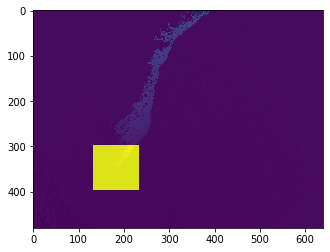

In [33]:
fig, ax = plt.subplots()
ax.imshow(frame_)

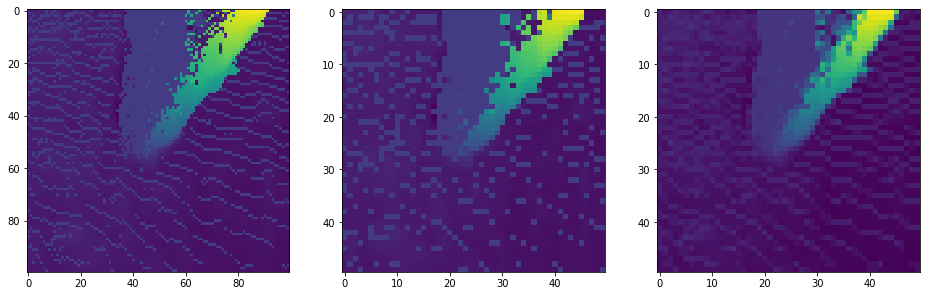

In [34]:
fig, ax = plt.subplots(1,3, figsize=(16,16))
ax[0].imshow(frame_clip)
ax[1].imshow(frame_clip[::2,::2])

from skimage.transform import resize
image_resized = resize(frame_clip, (frame_clip.shape[0] // 2, frame_clip.shape[1] // 2),
                       anti_aliasing=False)
ax[2].imshow(image_resized)

# check normalisation

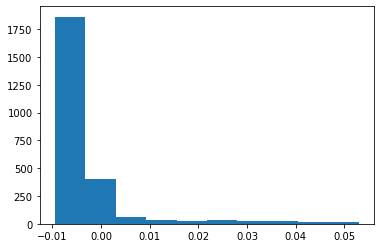

In [35]:
_=plt.hist(image_resized.reshape(-1))

In [36]:
tmp = image_resized.copy()

In [37]:
# tmp[tmp < 0] = 0
tmp[tmp > 0.04] = 0
tmp /= 0.04

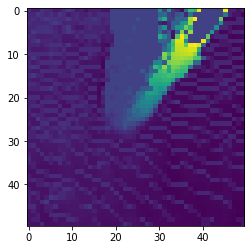

In [38]:
plt.imshow(tmp)